## General Steps
### 1.  Reading the Multispectral TIFF Images:

**Objective**: Extract the data from TIFF images captured by the drone.  

**Details**:  
Each TIFF image contains data from one of the four spectral bands:  
 - Green (G),  
 - Red (R),  
 - Red Edge (RE),  
 - Near-Infrared (NIR).  
 
Read these images and extract the pixel values for each band.  

### 2.  Aligning the Images and Correcting Distortion:

**Objective**: Ensure that the images from different spectral bands are perfectly aligned with each other and free from any distortions.  

**Details**:  
Due to possible movement of the drone or lens imperfections, the images might not be perfectly aligned. This step involves correcting any  
 such misalignment and distortion to ensure that the pixel data from each band corresponds to the same geographical location on the ground.  
 Techniques like image registration can be used here.


### 3. Calculating the NDVI for Each Pixel:
**`Objective`**:  
Compute the Normalized Difference Vegetation Index (NDVI) for each pixel using the extracted data.

**`Details`**: The NDVI is calculated using the following formula:

$$
NDVI = \frac{NIR - R}{NIR + R}
$$  
Where:  
NIR is the pixel value from the Near-Infrared band.  
R is the pixel value from the Red band.  
NDVI values range from -1 to +1, where higher values typically indicate healthier and more vigorous vegetation.


### Workflow  
`Read TIFF Images:`  
 Load the TIFF files corresponding to the Green, Red, Red Edge, and Near-Infrared bands.  

`Pre-process Images:`   
 Apply any necessary pre-processing steps like converting to grayscale if needed.  

`Align Images: `   
 Use techniques like feature matching and homography to align the images from different bands.  

`Calculate NDVI:`  
 Using the aligned Red and Near-Infrared band images, calculate the NDVI for each pixel.  
 
`Output Results:`  
 Save the NDVI image for further analysis or visualization.  


### 1.  Reading the Multispectral TIFF Images:

/home/zed/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


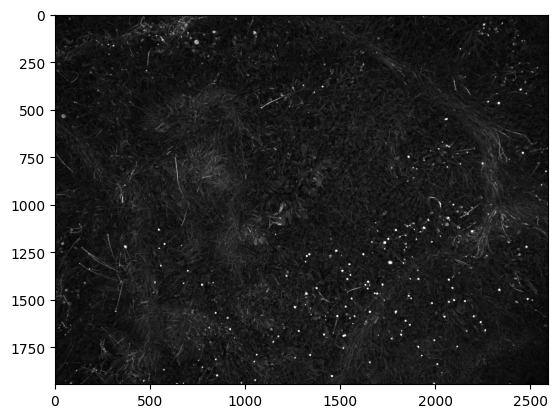

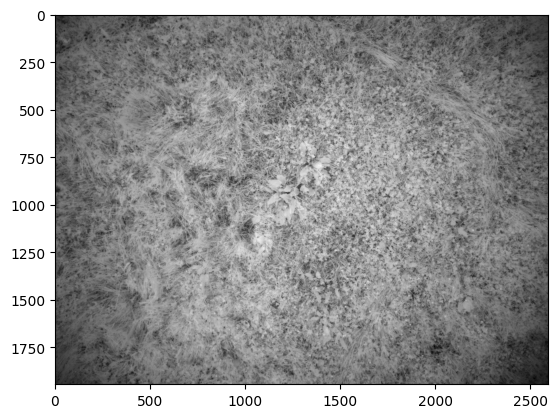

array([[9680, 9488, 9296],
       [9408, 9440, 9488],
       [9392, 9184, 9088]], dtype=uint16)

In [25]:
import numpy as np
import rasterio
import cv2 as cv
from rasterio.plot import show

def read_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read(1), src.transform

# Testing
green_data, green_transform = read_image('DJI_202405031358_001/DJI_20240503140325_0001_MS_G.TIF')
red_data, red_transform = read_image('DJI_202405031358_001/DJI_20240503140325_0001_MS_R.TIF')
nir_data, nir_transform = read_image('DJI_202405031358_001/DJI_20240503140325_0001_MS_NIR.TIF')
red_edge_data, red_edge_transform = read_image('DJI_202405031358_001/DJI_20240503140325_0001_MS_RE.TIF')


# plot images
show(red_data, transform=red_transform, cmap='gray')
# show(green_data, transform=green_transform, cmap='gray')
show(nir_data, transform=nir_transform, cmap='gray')
green_data[0:3, 0:3]
red_data[0:3, 0:3]
nir_data[0:3, 0:3]



### 2.  Aligning the Images and Correcting Distortion:


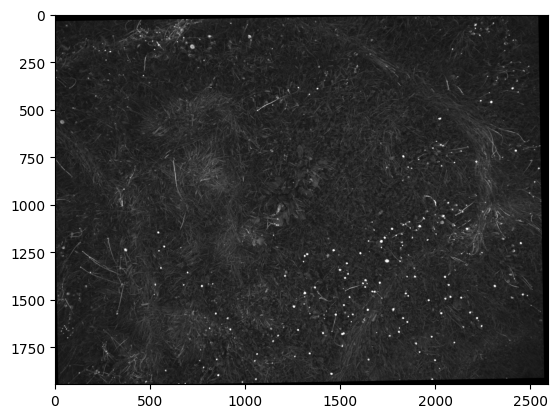

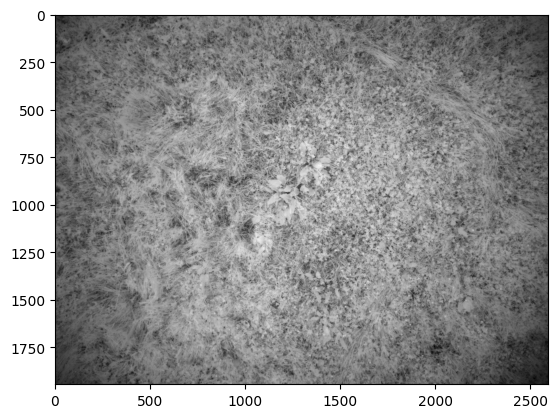

<Axes: >

In [26]:
# homography to align images
calibrated_Hmatrix = np.array([
    9.891065e-01,
    1.740813e-02,
    -1.592078e+01,
    -1.568817e-02,
    9.885082e-01,
    3.766531e+01,
    1.083204e-06,
    5.127963e-07,
    1.000000e+00
]).reshape(3, 3)


#src -> NIR

# dst -> red

alilgned_red = cv.warpPerspective(red_data, calibrated_Hmatrix, (red_data.shape[1], red_data.shape[0]))
show(alilgned_red, transform=red_transform, cmap='gray')
show(nir_data, transform=nir_transform, cmap='gray')
